In [1]:
import cvxpy as cp # python 3.7 로 해야.... 하루종일 걸려서 발견...
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
# import pickle 

In [2]:
df_tar = pd.read_csv("./data/Toy_data_target.csv")

In [3]:
# Date control 

df_tar['Date'] = df_tar.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d') )
df_tar = df_tar.set_index('Date')

In [4]:
df_tar.isna().sum()

TLT     2608
EMB     3413
AGG        0
Cash    1829
SPY        0
EFA        0
VWO     2087
GLD        0
DBC     2328
dtype: int64

In [46]:
# Nan value 우선적 제거 
df = df_tar.dropna(axis = 0)

df_t = df[df.index[1]:df.index[1000]]

# return & volatility 

logret = np.log(df_t/df_t.shift(1)).dropna()
T = logret.shape[0]

sigma = logret.cov() * T # annualize sigma (check again)
mu = logret.mean()*T



In [48]:
mu

TLT     0.347006
EMB     0.617836
AGG     0.257419
Cash    0.475345
SPY     0.629832
EFA     0.534786
VWO     0.410735
GLD     0.118676
DBC     0.371853
dtype: float64

In [32]:
class MVO:
    
    def __init__(self, mu, sigma, r_f):
        self.mu = mu
        self.sigma = sigma
        self.num_assets = mu.size
        self.r_f = r_f

    def solve_Markowitz_model(self, mu0):
        '''
        Sharpe raio maximization
        * mu0 : minimum return 
        '''
        
        w = cp.Variable(self.num_assets)
        
        ret = self.mu.values.T @ w      
        
#         vol = np.sqrt(w.T@self.sigma@w).values
        vol = cp.quad_form(w, self.sigma)
        
        sharpe = (ret-self.r_f)/vol
        
#         obj = cp.Maximize(sharpe)
        obj = cp.Minimize(vol)
        # long only, max 비중 0.25 이하
        constraints = [sum(w) == 1, ret>= mu0, 0<=w, w<=0.25]  
        
        cp.Problem(obj, constraints).solve()
    
        w_values = w.value

        opt_ret = self.mu.dot(w_values)
        
        opt_sig = np.sqrt(w_values.T @ self.sigma @ w_values)
        
        return opt_ret, opt_sig
    
    def draw_efficient_frontier(self, n_samples):
        pfo_returns = np.zeros(n_samples)
        pfo_vols = np.zeros(n_samples)
        pfo_SRs = np.zeros(n_samples)
        fig = plt.figure()

        for i in range(n_samples):
            # generating the weight vector w
            # short-sell is not allowed here since w vector has all positive components
            w = np.random.random([self.num_assets,1])
            if sum(w) == 0:
                continue
            # Scaling the weight vector
            w /= sum(w)
                        
            # Calculating Expected return
            ret = self.mu.T.dot(w)
            
            # Calculating Portfolio std
            vol = np.sqrt(w.T.dot(self.sigma).dot(w))
            
            # Save return, vol, shapr_ratio
            pfo_returns[i] = ret
            pfo_vols[i] = vol
            pfo_SRs[i] = (ret-self.r_f)/vol
        
        portfolio = {'Returns': pfo_returns,
                    'Volatility': pfo_vols,
                    'Sharpe ratio': pfo_SRs}
        
        df = pd.DataFrame(portfolio)
        
        plt.style.use('seaborn-dark')
        df.plot.scatter(x='Volatility', y='Returns', c='Sharpe ratio', cmap='RdYlGn', edgecolors='black', figsize=(8, 5), grid=True)
        plt.xlabel('Volatility (Std. Deviation)')
        plt.ylabel('Expected Returns')
        plt.title('Efficient Frontier')
            
        ef_risks = []
        ef_returns = []
        
        # Set the minimum and maximum required return
        ret, risk = self.solve_Markowitz_model(0)
        min_return = ret
        max_return = self.mu.max()
        
        # use 500 bins(linspace) for drawing the efficient frontier
        for i in np.linspace(min_return,max_return,500):
            
            # get the efficient risk and return for fixed required return
            ret, risk = self.solve_Markowitz_model(i)
            # append each efficient risk and return
            ef_returns.append(ret)
            ef_risks.append(risk)
        
        plt.plot(ef_risks, ef_returns, color = 'black', linestyle='solid', linewidth=5)
        
        for i in range(self.num_assets):
            try:
                plt.plot(np.sqrt(self.sigma[i,i]), self.mu[i], 'ws', markeredgecolor='k', markeredgewidth=1.5, markersize=8)
            except:
                continue        
        
        # Get the tangent portfolio's location and plot
        tan_sigma, tan_mu = self.find_tangent_portfolio(ef_risks, ef_returns)
        tan_line_x = np.linspace(0, ef_risks[-1] * 1.3, 2)
        
        # I fixed it since this line does not consider the risk free rate
        tan_line_y = tan_line_x * ((tan_mu - self.r_f)/ tan_sigma) + self.r_f
        
        plt.plot(tan_line_x, tan_line_y, color = 'blue', linestyle='dashed', linewidth=3)
        plt.plot(tan_sigma, tan_mu, marker='*', color='gold', markeredgecolor='k', markeredgewidth=2, markersize=20)
        
        # Add each companies to the graph with white squares
        for i in range(self.num_assets):
            plt.plot(np.sqrt(sigma.iloc[i,i]), mu.iloc[i], marker='s', color='white', markeredgecolor='k', markeredgewidth=1, markersize=5);
        
        plt.xlim(left=0.0)
        plt.show()
            
    def find_tangent_portfolio(self, ef_pfo_risks, ef_pfo_returns):

        # Calculate the Sharp Raio of all efficient points
        SR = (np.array(ef_pfo_returns) - self.r_f) / np.array(ef_pfo_risks)
        
        # Find the maximum location using np.argmax method
        iloc = np.argmax(SR)
        
        # Return the risk and return, where Sharp Ratio assumes it's maximum
        tan_sigma = ef_pfo_risks[iloc]
        tan_mu = ef_pfo_returns[iloc]
        
        return tan_sigma, tan_mu

IndexError: tuple index out of range

<Figure size 432x288 with 0 Axes>

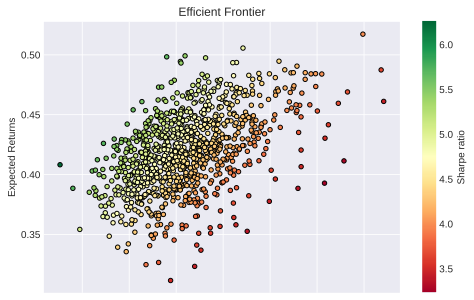

In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

test_mv = MVO(mu, sigma, r_f=0)
test_mv.draw_efficient_frontier(n_samples=1000)

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

<Figure size 432x288 with 0 Axes>

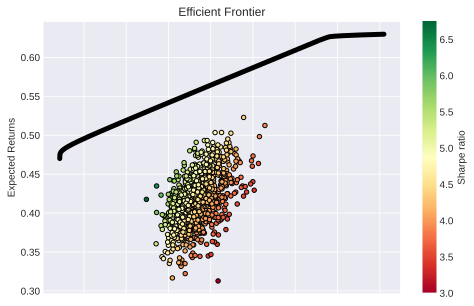

In [45]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

test_mv = mv_framework(mu, sigma, r_f=0)
test_mv.draw_efficient_frontier(n_samples=1000)

In [44]:
class mv_framework:
    
    def __init__(self, mu, sigma, r_f):
        self.mu = mu
        self.sigma = sigma
        self.num_assets = mu.size
        self.r_f = r_f
        
    def draw_efficient_frontier(self, n_samples):
        pfo_returns = np.zeros(n_samples)
        pfo_vols = np.zeros(n_samples)
        pfo_SRs = np.zeros(n_samples)
        fig = plt.figure()

        for i in range(n_samples):
            # generating the weight vector w
            # short-sell is not allowed here since w vector has all positive components
            w = np.random.random([self.num_assets,1])
            if sum(w) == 0:
                continue
            # Scaling the weight vector
            w /= sum(w)
                        
            # Calculating Expected return
            ret = self.mu.T.dot(w)
            
            # Calculating Portfolio std
            vol = np.sqrt(w.T.dot(self.sigma).dot(w))
            
            # Save return, vol, shapr_ratio
            pfo_returns[i] = ret
            pfo_vols[i] = vol
            pfo_SRs[i] = (ret-self.r_f)/vol
        
        portfolio = {'Returns': pfo_returns,
                    'Volatility': pfo_vols,
                    'Sharpe ratio': pfo_SRs}
        
        df = pd.DataFrame(portfolio)
        
        plt.style.use('seaborn-dark')
        df.plot.scatter(x='Volatility', y='Returns', c='Sharpe ratio', cmap='RdYlGn', edgecolors='black', figsize=(8, 5), grid=True)
        plt.xlabel('Volatility (Std. Deviation)')
        plt.ylabel('Expected Returns')
        plt.title('Efficient Frontier')
            
        ef_risks = []
        ef_returns = []
        
        # Set the minimum and maximum required return
        ret, risk = self.solve_Markowitz_model(0)
        min_return = ret
        max_return = self.mu.max()
        
        # use 500 bins(linspace) for drawing the efficient frontier : black line
        for i in np.linspace(min_return,max_return,500):
            
            # get the efficient risk and return for fixed required return
            ret, risk = self.solve_Markowitz_model(i)
            # append each efficient risk and return
            ef_returns.append(ret)
            ef_risks.append(risk)
        
        plt.plot(ef_risks, ef_returns, color = 'black', linestyle='solid', linewidth=5)
        
        for i in range(self.num_assets):
            try:
                plt.plot(np.sqrt(self.sigma[i,i]), self.mu[i], 'ws', markeredgecolor='k', markeredgewidth=1.5, markersize=8)
            except:
                continue        
        
        # Get the tangent portfolio's location and plot
        tan_sigma, tan_mu = self.find_tangent_portfolio(ef_risks, ef_returns)
        tan_line_x = np.linspace(0, ef_risks[-1] * 1.3, 2)
        
        # I fixed it since this line does not consider the risk free rate
#         tan_line_y = tan_line_x * ((tan_mu - self.r_f)/ tan_sigma) + self.r_f
        tan_line_y = ((tan_mu - self.r_f)/ tan_sigma) + self.r_f
    
        plt.plot(tan_line_x, tan_line_y, color = 'blue', linestyle='dashed', linewidth=3)
        plt.plot(tan_sigma, tan_mu, marker='*', color='gold', markeredgecolor='k', markeredgewidth=2, markersize=20)
        
        # Add each companies to the graph with white squares
        for i in range(self.num_assets):
            plt.plot(np.sqrt(sigma.iloc[i,i]), mu.iloc[i], marker='s', color='white', markeredgecolor='k', markeredgewidth=1, markersize=5);
        
        plt.xlim(left=0.0)
        plt.show()
        
    def solve_Markowitz_model(self, mu0):

        w = cp.Variable(self.num_assets)

        ret = self.mu.values.T @ w
        risk = cp.quad_form(w, self.sigma)

        # Setting the QP problem
        # Objective : Minimize the risk
        # Constraint : Budget constraint, required return and short-sell is not allowed here.
        
        prob = cp.Problem(cp.Minimize(risk),
                         [sum(w) == 1,
                         ret >= mu0,
                         w >= 0])
        prob.solve()
        return self.mu.dot(w.value), np.sqrt(w.value.dot(self.sigma).dot(w.value))
    
    def find_tangent_portfolio(self, ef_pfo_risks, ef_pfo_returns):

        # Calculate the Sharp Raio of all efficient points
        SR = (np.array(ef_pfo_returns) - self.r_f) / np.array(ef_pfo_risks)
        
        # Find the maximum location using np.argmax method
        iloc = np.argmax(SR)
        
        # Return the risk and return, where Sharp Ratio assumes it's maximum
        tan_sigma = ef_pfo_risks[iloc]
        tan_mu = ef_pfo_returns[iloc]
        
        return tan_sigma, tan_mu